In [43]:
from pathlib import Path
import pandas as pd
import cv2
import imageio
import xmltodict
import dicttoxml
import numpy as np
import shutil

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_path = Path('/mnt/ssd0_1/kashin/gr_mri_spine')
descr_path = base_path / 'descr'
imgs_path = base_path / 'images'

In [3]:
data = pd.concat(pd.read_csv(path) for path in descr_path.iterdir())

In [4]:
data.shape

(916, 20)

In [5]:
data['На срезе визуализируются межпозвоночные диски'].value_counts()

Не визуализируются (срез не пригоден для разметки)    531
Визуализируются (можно размечать)                     365
Name: На срезе визуализируются межпозвоночные диски, dtype: int64

In [6]:
data_viz = data[data['На срезе визуализируются межпозвоночные диски'] == 'Визуализируются (можно размечать)']

In [7]:
data_viz.shape

(365, 20)

In [8]:
data_viz = data_viz[~data_viz.XML.isnull()]

In [9]:
data_viz.shape

(356, 20)

In [10]:
def parse_row(row):
    path = row['Файлы'][:-2]
    path = imgs_path / path
    
    xml = xmltodict.parse(row['XML'])      
    if 'annotationgroup' in xml:
        xml = xml['annotationgroup']
    objects = xml['annotation']['object']

    return path, objects

In [11]:
labels = []
for row in data_viz.iterrows():
    row = row[1]
    path, objects = parse_row(row)
    labels.extend([o['name'] for o in objects])

In [12]:
pd.Series.value_counts(labels, False)

shejnyj-mezhpozvonochnyj-disk-zdorovyj                       961
grudnoj-mezhpozvonochnyj-disk-zdorovyj                       912
shejnyj-mezhpozvonochnyj-disk-patologicheskij                403
shejnyj-mezhpozvonochnyj-disk-s-podozreniem-na-patologiyu    338
grudnoj-mezhpozvonochnyj-disk-s-podozreniem-na-patalogiyu     52
grudnoj-mezhpozvonochnyj-disk-patologicheskij                 26
hernia                                                         1
protrusion                                                     1
dtype: int64

In [13]:
pd.Series.value_counts(labels, True)

shejnyj-mezhpozvonochnyj-disk-zdorovyj                       0.356719
grudnoj-mezhpozvonochnyj-disk-zdorovyj                       0.338530
shejnyj-mezhpozvonochnyj-disk-patologicheskij                0.149592
shejnyj-mezhpozvonochnyj-disk-s-podozreniem-na-patologiyu    0.125464
grudnoj-mezhpozvonochnyj-disk-s-podozreniem-na-patalogiyu    0.019302
grudnoj-mezhpozvonochnyj-disk-patologicheskij                0.009651
hernia                                                       0.000371
protrusion                                                   0.000371
dtype: float64

In [14]:
vc = pd.Series.value_counts(labels)

In [15]:
using_labels = vc[vc > 1].index.tolist()

In [16]:
len(using_labels)

6

In [17]:
indx2labels = dict(enumerate(using_labels))
labels2indx = {y: x for x, y in indx2labels.items()}

np.random.seed(42)
indx2color = plt.cm.get_cmap('gist_rainbow', len(using_labels))

In [18]:
def draw_objects(img, objs):
    img = img.copy()
    for o in objs:
        label = labels2indx[o['name']]
        c = np.array(indx2color(label)) * 255
        pt = o['polygon']['pt']
        a, b = pt[0], pt[2]
        img = cv2.rectangle(img, (int(a['x']), int(a['y'])), (int(b['x']), int(b['y'])),
                            c, 2)
    return img

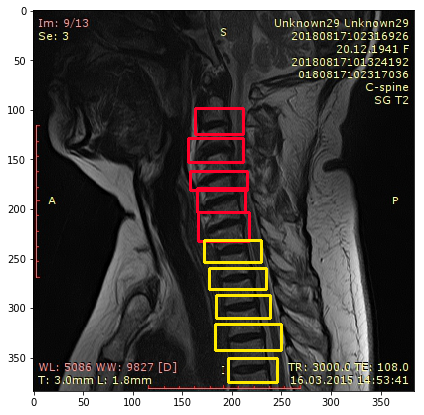

In [19]:
for row in data_viz.sample(1).iterrows():
    row = row[1]
    path, objects = parse_row(row)
    img = imageio.imread(path)
    
    plt.figure(figsize=(7, 7))
    img = draw_objects(img, objects)
    plt.imshow(img)

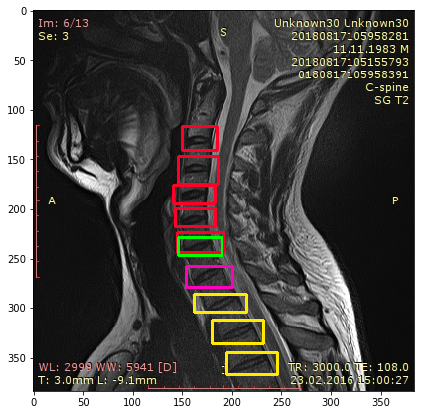

In [20]:
for row in data_viz[102:103].iterrows():
    row = row[1]
    path, objects = parse_row(row)
    img = imageio.imread(path)

    plt.figure(figsize=(7, 7))
    img = draw_objects(img, objects)
    plt.imshow(img)

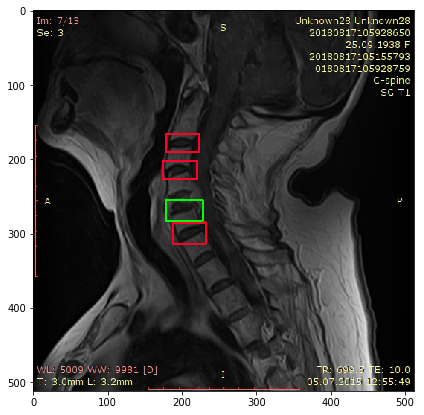

In [21]:
for row in data_viz[314:315].iterrows():
    row = row[1]
    path, objects = parse_row(row)
    img = imageio.imread(path)

    plt.figure(figsize=(7, 7))
    img = draw_objects(img, objects)
    plt.imshow(img)

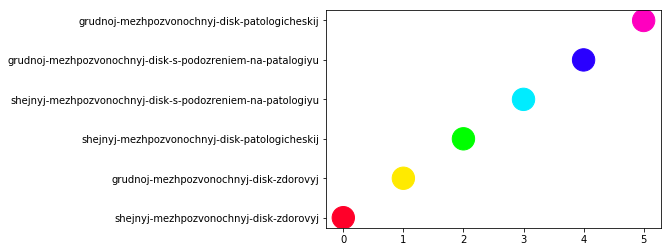

In [22]:
plt.scatter(indx2labels.keys(), indx2labels.values(),
            c=[indx2color(i) for i in range(len(indx2labels))], s=500)

### TODO: закрыть все надписи

## Split

In [23]:
def get_bounding_box(obj):
    if obj['name'] not in labels2indx:
        return None
    
    bb_obj = {}
    bb_obj['label'] = labels2indx[obj['name']]
    pt = obj['polygon']['pt']
    bb_obj['xmin'] = pt[0]['x']
    bb_obj['xmax'] = pt[1]['x']
    bb_obj['ymin'] = pt[0]['y']
    bb_obj['ymax'] = pt[2]['y']    
    return bb_obj

def preprocess_bounding_boxes(objs):
    bboxes = []
    for obj in objs:
        bb = get_bounding_box(obj)
        if bb is not None:
            bboxes.append(bb)
    return bboxes

In [24]:
from sklearn.model_selection import StratifiedKFold
import json

In [25]:
data_viz.shape[0] // 7 * 5

250

In [26]:
all_paths = []
all_objects = []
split_labels = []
for row in data_viz.iterrows():
    row = row[1]
    path, objects = parse_row(row)
    all_paths.append(path)    
    all_objects.append(preprocess_bounding_boxes(objects))
    
    # list of all labels in image
    classes = [labels2indx.get(o['name'], -1) for o in objects]
    
    # train-val-test split based on the most rare label on image
    # greater index mean more rare label
    split_labels.append(max(classes))

---

In [27]:
shapes = [str(imageio.imread(p).shape) for p in all_paths]
pd.Series.value_counts(shapes)

(384, 384, 3)    352
(512, 512, 3)      4
dtype: int64

In [28]:
shapes.index('(512, 512, 3)')

314

---

In [29]:
labels2indx

{'shejnyj-mezhpozvonochnyj-disk-zdorovyj': 0,
 'grudnoj-mezhpozvonochnyj-disk-zdorovyj': 1,
 'shejnyj-mezhpozvonochnyj-disk-patologicheskij': 2,
 'shejnyj-mezhpozvonochnyj-disk-s-podozreniem-na-patologiyu': 3,
 'grudnoj-mezhpozvonochnyj-disk-s-podozreniem-na-patalogiyu': 4,
 'grudnoj-mezhpozvonochnyj-disk-patologicheskij': 5}

In [30]:
pd.Series.value_counts(split_labels)

3    148
2     79
1     60
4     29
5     20
0     20
dtype: int64

In [31]:
split_labels.index(5)

102

In [32]:
folds = 7
skf = StratifiedKFold(n_splits=folds, random_state=42)

train_inds = []
val_inds = []
test_inds = []

In [33]:
for i, split in enumerate(skf.split(split_labels, split_labels)):
    if i == 0:
        val_inds = list(split[1])
    elif i == 1:
        test_inds = list(split[1])
    else:
        train_inds += list(split[1])

In [34]:
base_path.joinpath(f'split_{folds}.json').write_text(
    json.dumps({
        'train_inds': train_inds,
        'val_inds': val_inds,
        'test_inds': test_inds
    }, indent=True, sort_keys=True, default=int)
)

2441

In [35]:
def select_fold(items, inds):
    return [item for i, item in enumerate(items) if i in inds]

In [36]:
train_paths = select_fold(all_paths, train_inds)
val_paths = select_fold(all_paths, val_inds)
test_paths = select_fold(all_paths, test_inds)

train_objs = select_fold(all_objects, train_inds)
val_objs = select_fold(all_objects, val_inds)
test_objs = select_fold(all_objects, test_inds)

pip install https://github.com/Simon-Campbell/dicttoxml/archive/b0777caf0ccf64c97a9c47a70b9ced6e0c51ddf7.zip

Add fold_list parameter

## Save to voc

In [44]:
base_path

PosixPath('/mnt/ssd0_1/kashin/gr_mri_spine')

In [37]:
def obj_to_voc(path, obj):
    item = {'filename': path.name}
    img = imageio.imread(path)
    item['width'] = img.shape[1]
    item['height'] = img.shape[0]
    
    item['object'] = []
    for o in obj:
        o = o.copy()
        item['object'].append({
            'name': o.pop('label'),
            'bndbox': o
        })
    return dicttoxml.dicttoxml(item, attr_type=False, custom_root='annotation',
                               fold_list=False)

def save_to_voc(paths, objs, folder):
    for p, o in zip(paths, objs):
        o_xml = obj_to_voc(p, o)
        path_xml = folder / (p.name.split('.')[0] + '.xml')
        path_xml.write_bytes(o_xml)

In [54]:
train_imgs_folder = base_path / 'train_imgs'
train_anns_folder = base_path / 'train_annotations'
train_imgs_folder.mkdir(exist_ok=True)
train_anns_folder.mkdir(exist_ok=True)

val_imgs_folder = base_path / 'val_imgs'
val_anns_folder = base_path / 'val_annotations'
val_imgs_folder.mkdir(exist_ok=True)
val_anns_folder.mkdir(exist_ok=True)

test_imgs_folder = base_path / 'test_imgs'
test_anns_folder = base_path / 'test_annotations'
test_imgs_folder.mkdir(exist_ok=True)
test_anns_folder.mkdir(exist_ok=True)

In [60]:
save_to_voc(train_paths, train_objs, train_anns_folder)
save_to_voc(val_paths, val_objs, val_anns_folder)
save_to_voc(test_paths, test_objs, test_anns_folder)

## Copy images

In [68]:
def copy_imgs(paths, folder):
    for path in paths:
        shutil.copy(path, folder / path.name)

In [69]:
copy_imgs(train_paths, train_imgs_folder)
copy_imgs(val_paths, val_imgs_folder)
copy_imgs(test_paths, test_imgs_folder)